In [1]:
import sys
sys.path.append("..")
from damage_indicator_module import*

import copy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
set_plot_formatting()

Color for each building

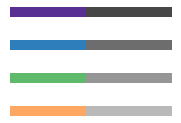

In [2]:
grayscale = False
n_colors = 4
min_intensity = 0.4 #0.6
max_intensity = 0.85

color_values = np.linspace(min_intensity, max_intensity, n_colors)
color_palettes = ['Oranges', 'Greens', 'Blues', 'Purples']
color_build = [mpl.cm.get_cmap(color_palettes[i])(color_values[i]) for i in range(len(color_values))] 
check_colors(color_build, 10)

#### INPUTS

In [3]:
# Building results file
building_id = ['ID1008','ID1012','ID1014','ID1021']
building_title = ['4-story RC frame', '8-story RC frame', '12-story RC frame', '20-story RC frame']

im = 'sa_avg'

# Damage indicator names
di_types = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "DI hinges", "$FDI_{max}^{bottom}$", "Beams DS>0",\
           "Columns DS>0", "$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$", "$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$"]

# Minimum value of each damage indicator to consider
di_min = [1e-4, 1e-6, 1e-7, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]

# Transformation for fit and display
di_transformation = "log"

n_scales = 7
n_mainshocks = 44


# Retrieve damage indicator data per buildng

In [4]:
damage_instances_data = dict()
for b_i in building_id:
    damage_instances_data[b_i] = pd.read_hdf('../1_Data_postprocessing/Damage_Instances_per_building.h5', key=b_i)
   

#### Assemble Damage Indicator Matrix per building [check manually those related to fractions of damaged components]

In [5]:
damage_instances_matrix = dict()

for b_i in building_id:
    # Retrieve data of current building
    current_building = damage_instances_data[b_i]
    
    # Matrix of Damage Indicators per damage instance        
    di_matrix = current_building[di_types[0]]
    di_matrix = np.vstack((di_matrix, current_building[di_types[1]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[2]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[3]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[4]]))
    di_matrix = np.vstack((di_matrix, 1 - np.stack(current_building['dsr_beams'].to_numpy())[:,0]))
    di_matrix = np.vstack((di_matrix, 1 - np.stack(current_building['dsr_columns'].to_numpy())[:,0]))
    di_matrix = np.vstack((di_matrix, np.stack(current_building['dsr_columns'].to_numpy())[:,0] - np.stack(current_building['dsr_columns'].to_numpy())[:,1]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[7]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[8]]))
    
    damage_instances_matrix[b_i] = copy.deepcopy(np.transpose(di_matrix))
del(di_matrix)

# Comparison of Damage Indicators

#### Reduction in median collapse capacity

In [6]:
k_min = 0.2

k = dict()

for b_i in building_id:
    # Retrieve data of current building
    k[b_i] = damage_instances_data[b_i]['$\kappa$'].values    
    damage_instances_matrix[b_i] = damage_instances_matrix[b_i][k[b_i] > k_min]
    damage_instances_data[b_i] = damage_instances_data[b_i][k[b_i] > k_min]
    k[b_i] = k[b_i][k[b_i] > k_min]

y_label = '\kappa'


#### Fit three-linear curve

In [7]:
parameters = dict()
N_seeds = 20

for b_i in building_id:
    parameters_bi = pd.DataFrame()
    
    for j, di in enumerate(di_types):        
        temp = fitPieceWiseFunc3LinLS(di, damage_instances_matrix[b_i][:, j], k[b_i], di_min[j], di_transformation, N_seeds)
    
        parameters_bi = parameters_bi.append(temp)
        print(b_i + ' ' + di)
        
    parameters[b_i] = copy.deepcopy(parameters_bi)
    parameters[b_i]
    
del(parameters_bi)


..\damage_indicator_module\damage_indicators.py:619: RuntimeWarning: invalid value encountered in double_scalars
  b1_0 = np.sum(x1.dot(y1)) / np.sum(x1.dot(x1))
..\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in greater
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in less_equal
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:536: RuntimeWarning: invalid value encountered in greater
  y_seg2 = y[x > param[2]]
..\damage_indicator_module\damage_indicators.py:538: RuntimeWarning: invalid value encountered in greater
  y_pred_seg1 = y_pred[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:538: RuntimeWarning: invalid value encountered in less_equal
  y_pred_seg1 = y_pred[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_mod

ID1008 $SDR_{peak}$
ID1008 $RSDR_{peak}$
ID1008 $FDI_{peak}$
ID1008 DI hinges
ID1008 $FDI_{max}^{bottom}$
ID1008 Beams DS>0
ID1008 Columns DS>0
ID1008 $Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$
ID1008 $Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-5.189105,-3.037405,-0.120962,-0.490955,0.990338,0.118189,"[0.024192434804439333, 0.09295593744442865, 0....",1.000000e-04,"[0.004644399999999998, 0.00557699341331932, 0....","[0.9903384662461382, 0.9903384662461382, 0.730..."
$RSDR_{peak}$,-8.708847,-3.403583,-0.045895,-0.419563,0.982887,0.111501,"[0.01140574809519912, 0.09086132982586725, 0.1...",1.000000e-06,"[1.64539e-05, 0.00016511858298525047, 0.033253...","[0.9828872956792428, 0.9828872956792428, 0.739..."
$FDI_{peak}$,-8.131882,-1.299526,-0.022912,-0.399992,0.983591,0.103393,"[0.01921912902056544, 0.040537134121506946, 0....",1.000000e-07,"[2.2639182824721564e-07, 0.0002940144060560974...","[0.9835910623151022, 0.9835910623151022, 0.827..."
DI hinges,-8.648042,-0.638119,-0.018524,-0.221720,0.984228,0.111927,"[0.015377451413878473, 0.05957835758649266, 0....",1.000000e-06,"[1.0000000000000004e-06, 0.0001754700219740177...","[0.9842278812318966, 0.9842278812318966, 0.835..."
$FDI_{max}^{bottom}$,-9.051428,-1.620773,-0.018468,-0.273810,0.983664,0.104732,"[0.01615407951568293, 0.049888957757775465, 0....",1.000000e-06,"[1.0000000000000004e-06, 0.0001172235499254635...","[0.9836638919515872, 0.9836638919515872, 0.846..."
Beams DS>0,-9.854446,-1.542764,-0.014000,-0.192159,0.989570,0.124065,"[0.004583059752310881, 0.14125863386920057, 0....",1.000000e-06,"[1.0000000000000004e-06, 5.251321847335154e-05...","[0.9895703460853496, 0.9895703460853496, 0.873..."
Columns DS>0,-13.815511,-1.982362,-0.009041,-0.220876,0.953998,0.110338,"[0.024942253535070846, 0.02517579206101972, 0....",1.000000e-06,"[1.0000000000000004e-06, 1.0000000000000004e-0...","[0.9539979920605759, 0.9539979920605759, 0.847..."
$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,-3.030089,-1.178649,-0.232949,0.334245,0.950000,0.115013,"[-0.008602054474337262, 0.045382419543201324, ...",1.000000e-06,"[0.048311320206163695, 0.048311320206163695, 0...","[0.95, 0.95, 0.5187090811682542, 0.91266639644..."
$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$,-0.769471,0.727833,-0.175584,-0.070478,0.976876,0.134880,"[0.07909890031248012, 0.16502286092323082, 0.1...",1.000000e-06,"[0.2818333333333334, 0.4632582625987106, 2.070...","[0.9768761358240481, 0.9768761358240481, 0.713..."


ID1012 $SDR_{peak}$
ID1012 $RSDR_{peak}$
ID1012 $FDI_{peak}$
ID1012 DI hinges
ID1012 $FDI_{max}^{bottom}$
ID1012 Beams DS>0
ID1012 Columns DS>0
ID1012 $Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$
ID1012 $Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-4.615789,-3.690893,-0.096016,-0.338289,1.014974,0.084902,"[0.04059278545122247, 0.07789827486243306, 0.1...",1.000000e-04,"[0.003451720000000001, 0.00989437515131623, 0....","[1.0149742234700072, 1.0149742234700072, 0.926..."
$RSDR_{peak}$,-6.770801,-4.049801,-0.054156,-0.279959,1.005099,0.086225,"[0.05046767591131873, 0.06966229795634482, 0.1...",1.000000e-06,"[1.4141999999999996e-05, 0.0011467757448963545...","[1.005099333009911, 1.005099333009911, 0.85774..."
$FDI_{peak}$,-4.916467,-1.762942,-0.034283,-0.288711,1.013504,0.079423,"[0.0420629866034381, 0.08465426727174163, 0.07...",1.000000e-07,"[9.999999999999994e-08, 0.007324966588159192, ...","[1.0135040223177916, 1.0135040223177916, 0.905..."
DI hinges,-4.631276,-0.477207,-0.027737,-0.315903,1.013548,0.083888,"[0.042019386499963396, 0.0925451579011003, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.009742318775346138,...","[1.0135476224212663, 1.0135476224212663, 0.898..."
$FDI_{max}^{bottom}$,-5.217877,-1.765052,-0.032620,-0.296673,1.015959,0.077659,"[0.03960796956658985, 0.06023895503879406, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.0054188236004128415...","[1.0159590393546398, 1.0159590393546398, 0.903..."
Beams DS>0,-6.395914,-2.019490,-0.016254,-0.171552,1.017007,0.106796,"[0.03856011133836135, 0.16626814340048657, 0.1...",1.000000e-06,"[1.0000000000000004e-06, 0.0016683603430430332...","[1.0170068975828683, 1.0170068975828683, 0.945..."
Columns DS>0,-10.873279,-3.245386,-0.011168,-0.202849,1.006596,0.087561,"[0.04897130072374911, 0.061466411483119265, 0....",1.000000e-06,"[1.0000000000000004e-06, 1.895809755488121e-05...","[1.0065957081974806, 1.0065957081974806, 0.921..."
$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,-0.461889,-0.278287,-2.020047,1.487644,0.950003,0.095794,"[0.06245828112724605, 0.02728199663221642, 0.1...",1.000000e-06,"[0.6300922020657882, 0.6300922022672683, 0.757...","[0.9500032704412783, 0.9500032704412783, 0.579..."
$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$,-0.915190,1.326546,-0.129966,-0.953546,1.016003,0.119811,"[0.132079941516146, 0.17366478052997125, 0.180...",1.000000e-06,"[0.21599999999999997, 0.40044064896034165, 3.7...","[1.0160034291204159, 1.0160034291204159, 0.724..."


ID1014 $SDR_{peak}$
ID1014 $RSDR_{peak}$
ID1014 $FDI_{peak}$
ID1014 DI hinges
ID1014 $FDI_{max}^{bottom}$
ID1014 Beams DS>0
ID1014 Columns DS>0
ID1014 $Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$
ID1014 $Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-4.462420,-3.577385,-0.185396,-0.466873,1.001741,0.075595,"[0.07209716021943602, 0.08531239191984707, 0.1...",1.000000e-04,"[0.0026110000000000005, 0.011534418156402495, ...","[1.001741203228576, 1.001741203228576, 0.83765..."
$RSDR_{peak}$,-9.461129,-5.243049,-0.023280,-0.168690,1.027935,0.085147,"[0.1220958702804067, 0.07738662773317984, 0.15...",1.000000e-06,"[4.213559999999999e-05, 7.78186467507363e-05, ...","[1.0279354872652209, 1.0279354872652209, 0.929..."
$FDI_{peak}$,-4.900097,-2.076426,-0.038735,-0.262856,1.000726,0.075851,"[0.06684273020551701, 0.07216387115090561, 0.1...",1.000000e-07,"[9.999999999999994e-08, 0.007445862590078323, ...","[1.000726185162848, 1.000726185162848, 0.89135..."
DI hinges,-3.630637,-0.678030,-0.042703,-0.251258,0.997775,0.077906,"[0.06777294575807291, 0.07873946422068978, 0.1...",1.000000e-06,"[1.0000000000000004e-06, 0.026499305405874293,...","[0.9977751806372663, 0.9977751806372663, 0.871..."
$FDI_{max}^{bottom}$,-5.699815,-2.068800,-0.031224,-0.291521,1.005522,0.073279,"[0.06002582346282881, 0.07257683350092703, 0.1...",1.000000e-06,"[1.0000000000000004e-06, 0.0033465836609132323...","[1.0055223029325104, 1.0055223029325104, 0.892..."
Beams DS>0,-5.369722,-2.071675,-0.026981,-0.247965,1.002394,0.093044,"[0.08415559672588524, 0.09449801074201947, 0.1...",1.000000e-06,"[1.0000000000000004e-06, 0.004655427394494296,...","[1.0023942473753944, 1.0023942473753944, 0.913..."
Columns DS>0,-13.815511,-3.979520,-0.011460,-0.170266,0.980892,0.084976,"[0.08465575019941618, 0.08102944555064762, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 1.0000000000000004e-0...","[0.9808923761959231, 0.9808923761959231, 0.868..."
$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,-0.296118,-0.181223,-4.843448,3.162346,0.950000,0.095877,"[0.09894600292070421, 0.02206359779247513, 0.0...",1.000000e-06,"[0.7436998417730186, 0.7436998417730186, 0.834...","[0.95, 0.95, 0.39351260834197965, 0.9666021234..."
$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$,-0.825494,0.768548,-0.158901,-0.374179,1.011034,0.113000,"[0.09926517929166379, 0.11483344515284799, 0.1...",1.000000e-06,"[0.15766666666666668, 0.43801854279815927, 2.1...","[1.0110339587946189, 1.0110339587946189, 0.757..."


ID1021 $SDR_{peak}$
ID1021 $RSDR_{peak}$
ID1021 $FDI_{peak}$
ID1021 DI hinges
ID1021 $FDI_{max}^{bottom}$
ID1021 Beams DS>0
ID1021 Columns DS>0
ID1021 $Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$
ID1021 $Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-5.143859,-3.873611,-0.107117,-0.325460,0.987135,0.092967,"[0.03859343300356899, 0.0538796214428775, 0.08...",1.000000e-04,"[0.00164587, 0.0058351283343981465, 0.02078318...","[0.9871353549443779, 0.9871353549443779, 0.851..."
$RSDR_{peak}$,-8.266672,-4.466780,-0.050084,-0.211201,0.995269,0.088293,"[0.09241032612338584, 0.08441756935066946, 0.0...",1.000000e-06,"[1.229099999999999e-05, 0.00025693893778387975...","[0.9952689190775931, 0.9952689190775931, 0.804..."
$FDI_{peak}$,-6.476578,-1.846627,-0.026437,-0.302274,0.978418,0.088085,"[0.03941402919004977, 0.05094363063950902, 0.0...",1.000000e-07,"[9.999999999999994e-08, 0.0015390679810445703,...","[0.9784180856424031, 0.9784180856424031, 0.856..."
DI hinges,-6.158476,-0.547317,-0.022250,-0.219215,0.981518,0.093502,"[0.04371924148834472, 0.0543219198514604, 0.11...",1.000000e-06,"[1.0000000000000004e-06, 0.00211547380724839, ...","[0.981517544874227, 0.981517544874227, 0.85667..."
$FDI_{max}^{bottom}$,-6.757690,-1.843794,-0.025254,-0.303897,0.980067,0.087645,"[0.04279796639439226, 0.05122579624454371, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.0011619097323705679...","[0.9800674346047482, 0.9800674346047482, 0.855..."
Beams DS>0,-7.341031,-1.904847,-0.022613,-0.373096,0.981517,0.103335,"[0.044074213845469834, 0.05459585022122104, 0....",1.000000e-06,"[1.0000000000000004e-06, 0.0006483818782869265...","[0.9815173940242798, 0.9815173940242798, 0.858..."
Columns DS>0,-13.609114,-12.826999,-0.113928,-0.024432,0.950000,0.102737,"[0.021670367686565384, -0.03610595088187263, -...",1.000000e-06,"[1.0000000000000004e-06, 1.2292400831650734e-0...","[0.9500000000000004, 0.9500000000000004, 0.860..."
$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,-0.164308,-0.057361,-4.706796,7.470094,0.950000,0.120194,"[0.09655565204196626, 0.03877933347370821, 0.0...",1.000000e-06,"[0.8358351166672612, 0.8484803723029666, 0.944...","[0.9500000000000066, 0.9500000000000066, 0.446..."
$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$,-0.795048,1.425455,-0.167551,-0.832582,0.989766,0.124577,"[0.09318819046540516, 0.15154954670259468, 0.1...",1.000000e-06,"[0.20366666666666672, 0.45155960260896977, 4.1...","[0.9897663026969551, 0.9897663026969551, 0.617..."


# Combined

In [8]:
# Concatenate results for all buildings
di_comb = damage_instances_matrix[building_id[0]]
k_comb = k[building_id[0]]
columnBool_comb = damage_instances_data[building_id[0]]['column_damage?'].values
dsr_cols_comb = 1 - np.stack(damage_instances_data[building_id[0]]['dsr_columns'].to_numpy())[:,0]

for b_i in building_id[1:]:
    di_comb = np.vstack((di_comb, damage_instances_matrix[b_i]))
    k_comb = np.hstack((k_comb, k[b_i]))

# Fit trilinear function    
parameters_comb = pd.DataFrame()
for j, di in enumerate(di_types):        
    
    temp = fitPieceWiseFunc3LinLS(di, di_comb[:, j], k_comb, di_min[j], di_transformation, N_seeds)
    parameters_comb = parameters_comb.append(temp)

parameters['comb'] = parameters_comb
del(parameters_comb)

# Selecting decision threshold

Retrieve/compute key points to analice threshold decision

In [9]:
# Retrieve the reduction in collapse capacity and the threshold value per building and damage indicator
k_at_a2 = np.zeros((len(building_id), len(di_types)))
a2 = np.zeros((len(building_id), len(di_types)))
for i, bi in enumerate(building_id):
    for j, di in enumerate(di_types):
        k_at_a2[i, j] = parameters[bi]['k for plot'][di][2]
        a2[i, j] = parameters[bi]['di for plot'][di][2]

        
# Retrieve common threshold value for combined analysis per damage indicator
a2_comb = np.zeros(len(di_types))
for j, di in enumerate(di_types):
    a2_comb[j] = parameters['comb']['di for plot'][di][2]

    
#  Compute the reduction in collapse capacity at the common threshold per damage indicator
k_at_a2_comb = np.zeros(len(di_types))
for j, di in enumerate(di_types):
    k_at_a2_comb[j] = predictPieceWiseFunc3LinLS(a2_comb[j], parameters['comb'].loc[di], di_transformation)

Select damage indicators to evaluate in terms of generality

In [10]:
di_to_plot = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "DI hinges", "$FDI_{max}^{bottom}$"]

# find index of the di_to_plot
di_index = []
for j, di in enumerate(di_to_plot):
    di_index.append(di_types.index(di))

#### Accuracy of own threshold

In [11]:
threshold_limits = [[0.001, 0.05], # range for SDR_{peak}
                   [0.0005, 0.03], # range for RSDR_{peak}
                   [0.05, 0.3],   # range for FDI_{peak}
                   [0.05, 1.5],   # range for DI hinges
                   [0.01, 0.5],   # range for DI_{sdr}
                   [0.005, 0.50], # range for Beams DS>0
                   [0.005, 0.10], # range for Columns DS>0
                   [0.5, 2],      # range for Sa main riato
                   [0.5, 2]]      # range for Sa_avg main riato

k_limit_list = [0.7, 0.8, 0.85, 0.9]

optimal_threshold = pd.DataFrame(columns = di_types, index = k_limit_list)
max_accuracy = pd.DataFrame(columns = di_types, index = k_limit_list)
max_fraction_FP = pd.DataFrame(columns = di_types, index = k_limit_list)

optimal_threshold_comb = pd.DataFrame(columns = di_types, index = k_limit_list)
max_accuracy_comb = pd.DataFrame(columns = di_types, index = k_limit_list)
max_fraction_FP_comb = pd.DataFrame(columns = di_types, index = k_limit_list)

for k_limit in k_limit_list:    
    for j, di in enumerate(di_types):
        optimal_threshold_klimit = np.zeros(len(building_id)) # rows: buildings
        max_accuracy_klimit = np.zeros(len(building_id))
        max_fraction_FP_klimit = np.zeros(len(building_id))
        
        for i, b_i in enumerate(building_id):

            optimal_threshold_klimit[i], max_accuracy_klimit[i], max_fraction_FP_klimit[i] = \
                    find_optimal_threshold(threshold_limits[j], damage_instances_matrix[b_i][:, j], k[b_i], k_limit)  
        
        optimal_threshold.loc[k_limit][di] = copy.deepcopy(optimal_threshold_klimit)
        max_accuracy.loc[k_limit][di] = copy.deepcopy(max_accuracy_klimit)
        max_fraction_FP.loc[k_limit][di] = copy.deepcopy(max_fraction_FP_klimit)
        
        optimal_threshold_comb.loc[k_limit][di], max_accuracy_comb.loc[k_limit][di], max_fraction_FP_comb.loc[k_limit][di] = \
                    find_optimal_threshold(threshold_limits[j], di_comb[:, j], k_comb, k_limit) 



Accuracy for different $\kappa$ limits combining all archetypes

In [12]:
print('Threshold')
optimal_threshold_comb
print('Balanced accuracy')
max_accuracy_comb
print('Red tag accuracy')
1-max_fraction_FP_comb

Threshold


,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
0.70,0.0311538,0.0148718,0.229487,0.942308,0.236154,0.208077,0.0220513,1,1.46154
0.80,0.028641,0.0110897,0.191026,0.682051,0.185897,0.208077,0.0171795,1,1.34615
0.85,0.0261282,0.00882051,0.171795,0.570513,0.173333,0.182692,0.0171795,1,1.19231
0.90,0.0248718,0.00655128,0.114103,0.310256,0.110513,0.106538,0.0171795,1,1.07692


Balanced accuracy


,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
0.70,0.817831,0.833648,0.865546,0.845574,0.869563,0.792513,0.753012,0.5,0.736415
0.80,0.83057,0.822601,0.866732,0.843359,0.86059,0.820552,0.776494,0.5,0.737812
0.85,0.815197,0.806657,0.856924,0.838327,0.847781,0.808784,0.76276,0.5,0.742634
0.90,0.797278,0.777917,0.836654,0.829356,0.835366,0.800359,0.750241,0.5,0.767349


Red tag accuracy


,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
0.70,0.835249,0.827586,0.896552,0.800766,0.873563,0.938697,0.8659,0,0.789272
0.80,0.82801,0.815725,0.882064,0.82801,0.869779,0.906634,0.857494,0,0.783784
0.85,0.815476,0.795635,0.849206,0.831349,0.825397,0.886905,0.797619,0,0.833333
0.90,0.737151,0.745962,0.863436,0.870778,0.859031,0.906021,0.71072,0,0.854626


#### Figure maximum accuracy threshold

ID1021
unsafe_cases = 141
safe_cases = 165
Max accuracy = [0.87008382]


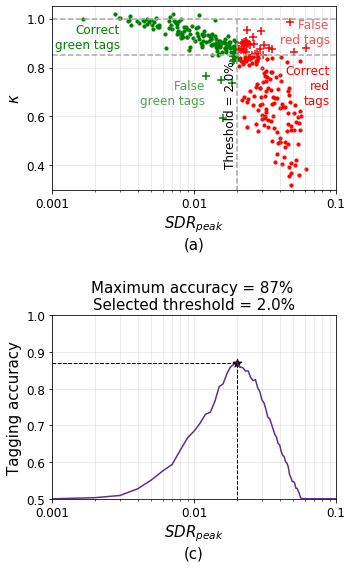

In [25]:
######## Performance of classification using 1 Damage Indicator ############
#############################################################
# kappa limit to judge building unsafe
k_limit = 0.85

# Condition 1

di_1 = 0
threshold_1_range = np.linspace(0.001, 0.1, 100)
threshold = 0.02
x_limits_plot = [0.001, 0.1]
figure_name = 'Tagging_error_SDR.pdf'

# di_1 = 2
# threshold_1_range = np.linspace(0.01, 1, 150)
# threshold = 0.16
# x_limits_plot = [0.01, 1]
# figure_name = 'Tagging_error_FDImax.pdf'

# Building
i = 3
b_i = building_id[i]


##############################################################

fig, ax_list = plt.subplots(2, 1, figsize=(5,8))

# Plot scatter
j = 0
ax = ax_list[j]
di_array = damage_instances_matrix[b_i][:, di_1]
x_data_space = 'log'
y_label = '$\kappa$'
if di_types[di_1] == '$RSDR_{peak}$':
    x_label = '$SDR_{residual}$'
elif di_types[di_1] == '$FDI_{peak}$':
    x_label = '$FDI_{max}$'
else: 
    x_label = di_types[di_1]

cg_idx = (k[b_i] > k_limit) & (di_array < threshold)
cr_idx = (k[b_i] < k_limit) & (di_array> threshold)
fr_idx = (k[b_i] > k_limit) & (di_array > threshold)
fg_idx = (k[b_i] < k_limit) & (di_array < threshold)
_ = ax.scatter(di_array[cg_idx], k[b_i][cg_idx], s=10, Color = 'g')
_ = ax.scatter(di_array[cr_idx], k[b_i][cr_idx], s=10, Color = 'r')
_ = ax.scatter(di_array[fg_idx], k[b_i][fg_idx], marker='+', s=50, Color = 'g')
_ = ax.scatter(di_array[fr_idx], k[b_i][fr_idx], marker='+', s=50, Color = 'r')

# Annotation
y_text = 0.4
rotation = 90
if di_1 <= 1:
    text = 'Threshold = {0:.1f}%'.format(100*threshold)
else:
    text = 'Threshold = {0:.2f}'.format(threshold)
_ = ax.text(threshold, y_text, text, rotation=rotation, ha='right', fontsize=12)

if di_1 == 0:
    _ = ax.text(0.012, 0.65, 'False\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.09, 0.90, 'False\nred tags', rotation=0, ha='right', color='red', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.003, 0.88, 'Correct\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=1, fontsize=12)
    _ = ax.text(0.09, 0.65, 'Correct\nred\ntags', rotation=0, ha='right', color='red', 
                alpha=1, fontsize=12)
elif di_1 == 2:
    _ = ax.text(0.04, 0.55, 'False\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.7, 0.90, 'False\nred tags', rotation=0, ha='right', color='red', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.09, 0.95, 'Correct\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=1, fontsize=12)
    _ = ax.text(0.28, 0.35, 'Correct\nred\ntags', rotation=0, ha='right', color='red', 
                alpha=1, fontsize=12)
else:
    _ = ax.text(0.04, 0.65, 'False\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.35, 0.90, 'False\nred tags', rotation=0, ha='right', color='red', 
                alpha=0.7, fontsize=12)
    _ = ax.text(0.05, 0.97, 'Correct\ngreen tags', rotation=0, ha='right', color='green', 
                alpha=1, fontsize=12)
    _ = ax.text(0.19, 0.4, 'Correct\nred\ntags', rotation=0, ha='right', color='red', 
                alpha=1, fontsize=12)

# Add reference line at threshold
_ = ax.plot([threshold, threshold], [0, 1], linestyle='--', Color='darkgray', label='_nolegend_')

# Add reference line in no reduction of collapse capacity
_ = ax.plot(x_limits_plot, [1, 1], linestyle='--', Color='darkgray', label='_nolegend_')
_ = ax.plot(x_limits_plot, [k_limit, k_limit], linestyle='--', Color='darkgray', label='_nolegend_')

# Format the plot and add title with the threshold
if di_1 == 0:
    _ = ax.set_xlabel(x_label+'\n(a)')
else:
    _ = ax.set_xlabel(x_label+'\n(b)')

_ = ax.set_ylabel(y_label)

_ = ax.set_xlim(x_limits_plot)
_ = ax.set_ylim([0.3, 1.05])
_ = ax.grid(which='both', alpha=0.3)

if x_data_space == "log":
    _ = ax.set_xscale('log')
    _ = ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))

#  Plot maximum accuracy
j = 1
ax = ax_list[j]

# Pull out damage indicators
di_condition_1 = damage_instances_matrix[b_i][:, di_1]

# Compute safe and unsafe cases based on kappa
unsafe_cases = np.count_nonzero(k[b_i][k[b_i] < k_limit])
safe_cases = np.count_nonzero(k[b_i][k[b_i] >= k_limit])

print(b_i)
print('unsafe_cases = ' + str(unsafe_cases))    
print('safe_cases = ' + str(safe_cases))

fraction_FP = np.zeros(len(threshold_1_range))
fraction_FN = np.zeros(len(threshold_1_range))
accuracy = np.zeros(len(threshold_1_range))
for th_i, threshold_1 in enumerate(threshold_1_range):

    # Compute safe and unsafe cases predictions based on damage indicator conditions
    fraction_FP[th_i], fraction_FN[th_i], accuracy[th_i] = evaluate_thresholds(di_condition_1, threshold_1, 0, 1, k[b_i], k_limit)    

_ = ax.plot(threshold_1_range, accuracy, color = color_build[i], label = building_title[i])
opt_idx = np.where(accuracy == np.amax(accuracy))
threshold_1_opt = threshold_1_range[opt_idx]
opt_accuracy = accuracy[opt_idx]
print('Max accuracy = ' + str(opt_accuracy))
_ = ax.scatter(threshold_1_opt, opt_accuracy, marker = "*", s = 80, color = 'k')
_ = ax.plot([0, threshold_1_opt], [opt_accuracy, opt_accuracy], linewidth = 1, linestyle = '--', color = 'k')
_ = ax.plot([threshold_1_opt, threshold_1_opt], [0, opt_accuracy], linewidth = 1, linestyle = '--', color = 'k')

# Formatting
_ = ax.grid(which='both', alpha = 0.3)
if di_1 == 0:
    _ = ax.set_xlabel(x_label+'\n(c)')
else:
    _ = ax.set_xlabel(x_label+'\n(d)')
                  
_ = ax.set_ylabel('Tagging accuracy')
_ = ax.set_ylim([0.5, 1])
_ = ax.set_xlim([np.amin(threshold_1_range), np.amax(threshold_1_range)])
if di_1 <= 1:
    _ = ax.set_title('\nMaximum accuracy = {0:.0f}'.format(opt_accuracy[0]*100) + '% \n' \
                      + 'Selected threshold = {0:.1f}'.format(100*threshold_1_opt[0]) + '%')
else:
    _ = ax.set_title('\nMaximum accuracy = {0:.0f}'.format(opt_accuracy[0]*100) + '% \n' \
                  + 'Selected threshold = {0:.2f}'.format(threshold_1_opt[0]))
if x_data_space == "log":
    _ = ax.set_xscale('log')
    _ = ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))

plt.tight_layout()
plt.savefig(figure_name)

#### Plot individual threshold before cliff with the threshold at k=0.9 and the common threshold

In [14]:
# di_to_plot = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "$DI_{sdr}$"]
# ylimits = [[0, 0.06], [0, 0.035], [0, 0.3], [0, 0.3]]
di_to_plot = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "$FDI_{max}^{bottom}$"]
di_labels = ["$SDR_{peak}$", "$SDR_{residual}$", "$FDI_{max}$", "$FDI_{max}^{bottom}$"]
ylimits = [[0, 6], [0, 3.5], [0, 0.3], [0, 0.3]]

# di_to_plot = ["$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{design}$", "$Sa(T_1)^{mainshock}/Sa(T_1)^{design}$", "DI hinges", "$DI_{sdr}$"]
# ylimits = [[0, 2], [0, 5], [0, 0.7], [0, 0.4]]

# find index of the di_to_plot
di_index = []
for j, di in enumerate(di_to_plot):
    di_index.append(di_types.index(di))

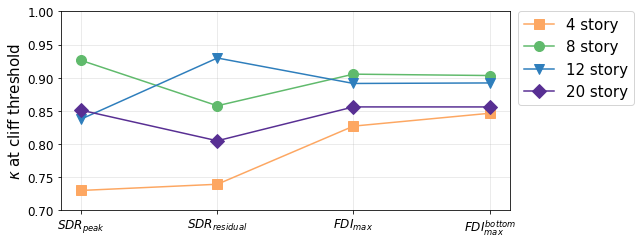

In [15]:
fig = plt.figure(figsize=(9, 3.5))

groups = np.arange(len(di_to_plot))
marker_type = ['s', 'o', 'v', 'D', 'P']

legend_names = ['4 story', '8 story', '12 story', '20 story', 'Combined']

for bi_i in range(len(building_id)):
    _ = plt.plot(groups, k_at_a2[bi_i, di_index], marker = marker_type[bi_i], markersize = 10, color=color_build[bi_i], alpha=1)
    
# _ = plt.plot(groups, k_at_a2_comb[di_index], marker = marker_type[len(building_id)], markersize = 10, color='black')

_ = plt.ylabel("$\kappa$ at cliff threshold")
# _ = plt.ylabel(y_label)
_ = plt.xticks(groups, di_labels)
# _ = plt.xlim([-bar_width*len(building_id), 2.35*bar_width*len(di_types)*len(building_id)])
_ = plt.ylim([0.7, 1.0])
_ = plt.grid(which = 'both',alpha = 0.3)
_ = plt.legend(legend_names, bbox_to_anchor=(1, 1.04))
# _ = plt.legend(legend_names, ncol=len(building_id)+1, loc='best')

plt.tight_layout()
plt.savefig('Generality_Cliff.pdf')

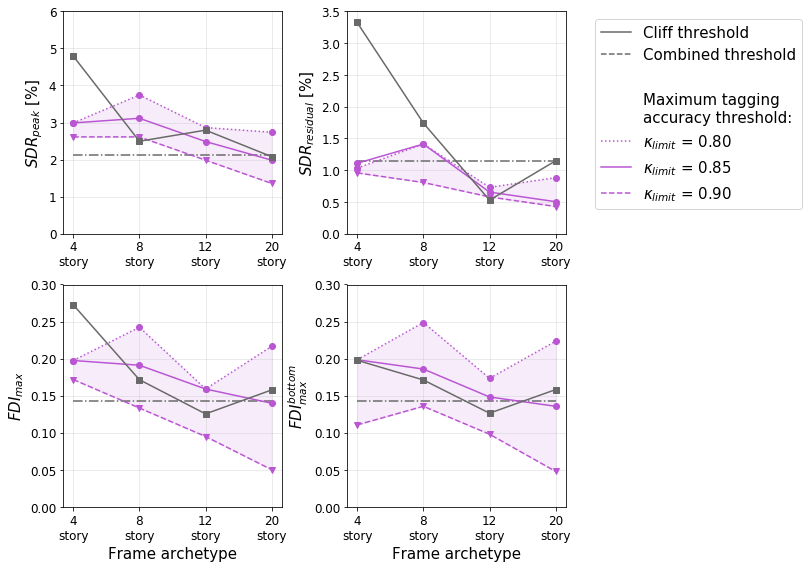

In [16]:
fig = plt.figure(figsize=(12, 8))

groups = np.arange(len(building_id))
xtick_names = ['4\nstory', '8\nstory', '12\nstory', '20\nstory']
marker_type = ['s', 'o', 'v']

plot_i = 0
for j in range(len(di_to_plot)):
    # Locate the subplot
    if plot_i <= 2:
        ax = plt.subplot2grid((2, 3), (0, plot_i), rowspan=1, colspan=1) 
    else:
        ax = plt.subplot2grid((2, 3), (1, plot_i - 3), rowspan=1, colspan=1) 
    
    # Plot lines
    if j <= 1:
        a2_comb[j] = a2_comb[j]*100
        a2[:, di_index[j]] = a2[:, di_index[j]]*100        
        optimal_threshold.loc[0.8][di_to_plot[j]] = optimal_threshold.loc[0.8][di_to_plot[j]]*100
        optimal_threshold.loc[0.85][di_to_plot[j]] = optimal_threshold.loc[0.85][di_to_plot[j]]*100
        optimal_threshold.loc[0.9][di_to_plot[j]] = optimal_threshold.loc[0.9][di_to_plot[j]]*100
        if di_to_plot[j] == '$RSDR_{peak}$':
            y_label_name = '$SDR_{residual}$ [%]'
        else:
            y_label_name = di_to_plot[j] + ' [%]'
        
    else:
        if di_to_plot[j] == 'DI hinges':
            y_label_name = '$DI_{hinges}$'
        elif di_to_plot[j] == "$FDI_{peak}$":
            y_label_name = '$FDI_{max}$'
        else:
            y_label_name = di_to_plot[j]
    
    _ = plt.plot(groups, a2[:, di_index[j]], markersize = 6, marker = marker_type[0], label = 'Cliff Threshold',
                 color='dimgray', zorder=5) # individual threshold
    
    # Plot combined
    _ = plt.plot(groups, np.ones(len(groups))*a2_comb[di_index[j]], linestyle='dashdot', 
                 color='dimgray', label = 'Common cliff threshold') 

    # Plot threshold for different kappas
#     _ = plt.plot(groups, a_k0_85[:, di_index[j]], markersize = 6, marker = marker_type[j], color='red') # threshold at k=0.9
    _ = plt.plot(groups, optimal_threshold.loc[0.8][di_to_plot[j]], markersize = 6, marker = marker_type[1], 
                 color = 'mediumorchid', linestyle = 'dotted', label = 'Threshold at \nMax. tagging accuracy \n[red tags $\kappa$<0.8]')
    _ = plt.plot(groups, optimal_threshold.loc[0.9][di_to_plot[j]], markersize = 6, marker = marker_type[2], 
                 color = 'mediumorchid', linestyle = 'dashed', label = '\nThreshold at Max. tag accuracy \n[red tags $\kappa$<0.9]')
    _ = plt.plot(groups, optimal_threshold.loc[0.85][di_to_plot[j]], markersize = 6, marker = marker_type[1], 
                 color = 'mediumorchid', label = '\nThreshold at Max. tag accuracy \n[red tags $\kappa$<0.85]')
    
    _ = plt.fill_between(groups, optimal_threshold.loc[0.8][di_to_plot[j]], optimal_threshold.loc[0.9][di_to_plot[j]], 
                         color = 'mediumorchid', alpha=0.1)
    
    _ = plt.ylabel(y_label_name)
    _ = plt.xticks(groups, xtick_names)
    _ = plt.ylim(ylimits[j])
    _ = plt.grid(which = 'both',alpha = 0.3)
    if plot_i == 1:
        
        legend = [Line2D([0], [0], label='Cliff threshold', linestyle='-', color='dimgray'),
                  Line2D([0], [0], label='Combined threshold', linestyle='dashed', color='dimgray'),
                  Patch(color='white'), Patch(color='white', label='Maximum tagging\naccuracy threshold:'),
                  Line2D([0], [0], label='$\kappa_{limit}$ = 0.80', color='mediumorchid', linestyle='dotted'),
                  Line2D([0], [0], label='$\kappa_{limit}$ = 0.85', color='mediumorchid'),
                  Line2D([0], [0], label='$\kappa_{limit}$ = 0.90', color='mediumorchid', linestyle='dashed')]
        _ = plt.legend(handles=legend, bbox_to_anchor=(1.1, 1))#, loc='center left', handlelaccuracy ength=handlelengthhazard, handletextpad=handletextpad)   
        
    if plot_i > 2:
        _ = plt.xlabel('Frame archetype')
    
    if plot_i == 1:
        plot_i += 2
    else:
        plot_i += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.savefig('Generality.pdf')

# Accuracy of own threshold

In [17]:
k_limit = 0.85

balanced_accuracy = list(max_accuracy.loc[k_limit].to_numpy())
balanced_accuracy = np.array(balanced_accuracy).T
balanced_accuracy = pd.DataFrame(data = balanced_accuracy, columns = di_types, index = building_id)
balanced_accuracy

accuracy_red_tags = list(1 - max_fraction_FP.loc[k_limit].to_numpy())
accuracy_red_tags = np.array(accuracy_red_tags).T
accuracy_red_tags = pd.DataFrame(data = accuracy_red_tags, columns = di_types, index = building_id)
accuracy_red_tags

,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
ID1008,0.777991,0.781077,0.826650,0.805598,0.806130,0.810324,0.807961,0.5,0.746062
ID1012,0.861156,0.831357,0.878725,0.845367,0.879293,0.788461,0.872819,0.5,0.706721
ID1014,0.878461,0.877687,0.901624,0.884892,0.893903,0.871257,0.880268,0.5,0.781282
ID1021,0.873630,0.845197,0.869568,0.865957,0.866538,0.864539,0.772598,0.5,0.765506


,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
ID1008,0.728395,0.734568,0.839506,0.845679,0.777778,0.882716,0.864198,0.0,0.802469
ID1012,0.863158,0.789474,0.884211,0.831579,0.894737,0.821053,0.905263,1.0,0.915789
ID1014,0.896226,0.924528,0.867925,0.933962,0.877358,0.886792,0.830189,1.0,0.811321
ID1021,0.929078,0.829787,0.914894,0.865248,0.914894,0.929078,0.581560,1.0,0.900709


# Accuracy of general threshold

In [18]:
threshold = np.array([[0.025, 0.010, 0.17, 0.17*3, 0.17, 0.10, 0.10, 1.3, 1.3 ], 
                      [0.025, 0.010, 0.17, 0.17*3, 0.17, 0.10, 0.10, 1.3, 1.3 ], 
                      [0.025, 0.010, 0.17, 0.17*3, 0.17, 0.10, 0.10, 1.3, 1.3 ], 
                      [0.025, 0.010, 0.17, 0.17*3, 0.17, 0.10, 0.10, 1.3, 1.3 ]])
                      
balanced_accuracy_gen = np.zeros([len(building_id), len(di_types)])
fraction_FP = np.zeros([len(building_id), len(di_types)])
fraction_FN = np.zeros([len(building_id), len(di_types)])

for i, b_i in enumerate(building_id):
    for j, di in enumerate(di_types):
        
        fraction_FP[i, j], fraction_FN[i, j], balanced_accuracy_gen[i, j] = evaluate_one_threshold(
            damage_instances_matrix[b_i][:, j], threshold[i, j], k[b_i], k_limit) 

        
# Add combined data
building_name = ['4-story','8-story','12-story','20-story']

for j, di in enumerate(di_types):
    fraction_FP[-1, j], fraction_FN[-1, j], balanced_accuracy_gen[-1, j] = evaluate_one_threshold(
                di_comb[:, j], threshold[-1, j], k_comb, k_limit) 
        
balanced_accuracy_gen = pd.DataFrame(data = balanced_accuracy_gen, index = building_id, columns = di_types)
balanced_accuracy_gen

accuracy_red_tags_gen = pd.DataFrame(data = 1-fraction_FP, index = building_id, columns = di_types)
accuracy_red_tags_gen

,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
ID1008,0.752597,0.776905,0.817944,0.799234,0.793614,0.733206,0.804874,0.5,0.745700
ID1012,0.804102,0.787818,0.858735,0.826439,0.853472,0.712478,0.695873,0.5,0.649049
ID1014,0.878461,0.858139,0.878297,0.876232,0.878555,0.833591,0.535248,0.5,0.760701
ID1021,0.809233,0.800842,0.853772,0.834561,0.844931,0.778841,0.657201,0.5,0.734670


,$SDR_{peak}$,$RSDR_{peak}$,$FDI_{peak}$,DI hinges,$FDI_{max}^{bottom}$,Beams DS>0,Columns DS>0,$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$,$Sa(T_1)_{avg}^{mainshock}/Sa(T_1)_{avg}^{DBE}$
ID1008,0.808642,0.746914,0.870370,0.777778,0.814815,0.962963,0.858025,0.0,0.808642
ID1012,0.936842,0.852632,0.905263,0.915789,0.894737,0.978947,0.410526,0.0,0.673684
ID1014,0.896226,0.820755,0.811321,0.886792,0.801887,0.990566,0.075472,0.0,0.745283
ID1021,0.835317,0.761905,0.851190,0.861111,0.829365,0.976190,0.371032,0.0,0.771825


# Accuracy results

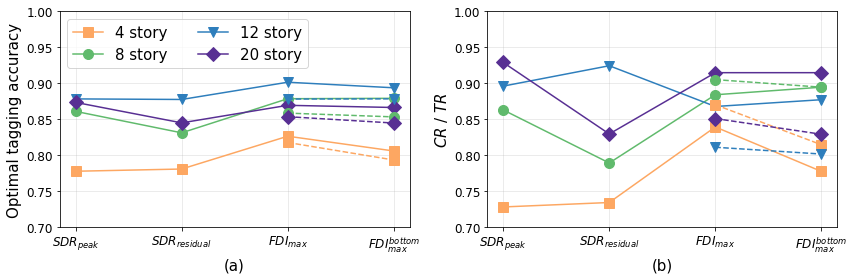

In [19]:
fig = plt.figure(figsize=(12, 4))

groups = np.arange(len(di_to_plot))
legend_names = ['4 story', '8 story', '12 story', '20 story', 'Combined']
bar_width = 0.1
marker_type = ['s', 'o', 'v', 'D', 'P']


ax = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1) 

for i, bi in enumerate(building_id):
    _ = ax.plot(groups, balanced_accuracy.loc[bi][di_to_plot], marker = marker_type[i], alpha = 1, markersize = 10, color = color_build[i])

_ = ax.set_ylabel('Optimal tagging accuracy')

_ = plt.xticks(groups, di_labels)
_ = ax.set_ylim([0.7, 1])
_ = ax.grid(which = 'both',alpha = 0.3)
_ = ax.legend(legend_names, ncol =2, loc='upper left')

# Add accuracy for general tagging threshold
for i, bi in enumerate(building_id):
    _ = ax.plot([2, 3], balanced_accuracy_gen.loc[bi][["$FDI_{peak}$", "$FDI_{max}^{bottom}$"]], marker = marker_type[i], 
                linestyle='dashed', alpha = 1, markersize = 10, color = color_build[i])
    
_ = ax.set_xlabel('(a)')
    
ax = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1) 

for i, bi in enumerate(building_id):
    _ = ax.plot(groups, accuracy_red_tags.loc[bi][di_to_plot], marker = marker_type[i], alpha = 1, markersize = 10, color = color_build[i])

_ = ax.set_ylabel('$CR$ / $TR$')

_ = plt.xticks(groups, di_labels)
_ = ax.set_ylim([0.7, 1])
_ = ax.grid(which = 'both',alpha = 0.3)

# Add accuracy for general tagging threshold
for i, bi in enumerate(building_id):
    _ = ax.plot([2, 3], accuracy_red_tags_gen.loc[bi][["$FDI_{peak}$", "$FDI_{max}^{bottom}$"]], marker = marker_type[i], 
                linestyle='dashed', alpha = 1, markersize = 10, color = color_build[i])

_ = ax.set_xlabel('(b)')

plt.tight_layout()

plt.savefig('tag_accuracy.pdf')